# Visualization of Feral Cat Segmentation Dataset

In [7]:
import os
from pathlib import Path
import json

from PIL import Image
import numpy as np
from pycocotools import mask as mask_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

root = r"D:\storage\feral-cat-segmentation.v1i.sam2"
target_size = [224, 224]

def process_segmentation(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)

    annotations = data.get('annotations', [])
    if not annotations:
        print(f"Error: No annotations found in {json_path}. Skipping...")
        return [], []  # Skip processing this image

    masks = []
    mask = []
    resized_annotations = []

    image_info = data.get('image', {})
    image_id = image_info.get('image_id')
    file_name = image_info.get('file_name')
    original_height = image_info.get('height')
    original_width = image_info.get('width')

    resize_factor_x = target_size[0] / original_width
    resize_factor_y = target_size[1] / original_height

    for annotation in annotations:
        annotation_id = annotation.get('id')

        # Decode RLE segmentation
        rle = annotation.get('segmentation')
        binary_mask = mask_utils.decode(rle)

        # Convert to PIL Image and resize
        mask_image = Image.fromarray(binary_mask.astype(np.uint8) * 255)
        resized_mask = mask_image.resize(target_size, Image.NEAREST)

        # Convert back to numpy array and normalize
        resized_mask_array = np.array(resized_mask) / 255
        # masks.append(resized_mask_array)

        # Resize bounding box
        original_bbox = annotation.get('bbox')
        resized_bbox = [
            original_bbox[0] * resize_factor_x,
            original_bbox[1] * resize_factor_y,
            original_bbox[2] * resize_factor_x,
            original_bbox[3] * resize_factor_y
        ]

        # Update annotation with resized values
        resized_annotation = annotation.copy()
        resized_annotation['bbox'] = resized_bbox
        resized_annotation['area'] = annotation.get(
            'area') * resize_factor_x * resize_factor_y

        # Create RLE for the resized mask
        resized_mask_binary = resized_mask_array.astype(np.uint8)
        masks.append(resized_mask_binary)
        resized_rle = mask_utils.encode(np.asfortranarray(resized_mask_binary))
        resized_rle['counts'] = resized_rle['counts'].decode('utf-8')
        resized_annotation['segmentation'] = resized_rle

        resized_annotations.append(resized_annotation)

    mask = np.array(masks[0])
    for i in range(1, len(masks)):
        mask = mask | np.array(masks[i])

    # Convert masks to numpy array
    # masks_array = np.array(masks)
    mask = np.array(mask)

    return mask, file_name


def preprocess_catpp():
    """Preprocess cat pictures into parquet files for speed and space efficiency"""

    # Checks
    root_path = Path(root)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory {root} does not exist.")

    folders = ['test', 'train', 'valid']
    folder_paths = [root_path / p for p in folders]
    for i, p in enumerate(folder_paths):
        if not p.exists():
            raise FileNotFoundError(
                f"Folder {folders[i]} at {p} does not exist.")

    # Preprocess images and segmentations
    num_data = [0, 0, 0]

    transform = transforms.Compose([
        transforms.Resize(target_size,
                          interpolation=transforms.InterpolationMode.BILINEAR),
        # transforms.ToTensor(),
        # transforms.Normalize(
        #     mean=[
        #         0.48235,
        #         0.45882,
        #         0.40784,
        #     ],
        #     std=[
        #         0.00392156862745098,
        #         0.00392156862745098,
        #         0.00392156862745098,
        #     ],
        # )
    ])

    for i, p in enumerate(folder_paths):
        all_images_path = list(p.glob("*.jpg"))
        all_json_path = list(p.glob("*.json"))

        imgs = []
        masks = []
        errors = []

        print("### Number of files ###", "\nImages:", len(all_images_path),
              "\t|\tJson:", len(all_json_path))

        # min_len = min(len(all_images_path), len(all_json_path))

        out_dir = root_path / f"{folders[i]}_mask"
        out_dir.mkdir(parents=True, exist_ok=True)

        # load data
        for j in tqdm(range(12)):
            img_path = all_images_path[j]
            json_path = all_json_path[j]

            # images
            img = Image.open(img_path)

            img = np.array(transform(img))

            # json
            mask, file_name = process_segmentation(json_path)

            if out_dir and len(mask) != 0:
                mask_path = os.path.join(out_dir, file_name)
                mask_image = Image.fromarray((mask * 255).astype(np.uint8))
                # mask_image.save(mask_path)

                num_data[i] += 1

                imgs.append(img)
                masks.append(mask)

        if len(errors) == 0:
            if imgs and masks:
                # pl.DataFrame(rows).write_parquet(
                #     f"{root_path}/{folders[i]}_dataset.parquet")

                # pl.DataFrame(rows).write_csv(
                #     f"{root_path}/{folders[i]}_dataset.csv",
                #     include_header=False,
                #     include_bom=False)

                # with open(f"{root_path}/{folders[i]}_dataset.pkl",
                #           "wb") as pkl_file:
                #     pickle.dump(rows_pickle, pkl_file)
                fig, axes = plt.subplots(6, 4, figsize=(12, 18))  # 6 rows, 4 columns

                for r in range(6):  # 6 rows
                    for c in range(4):  # 4 columns
                        idx = r//2 * 4 + c  # Compute index

                        if r % 2 == 0:  # Even rows (0, 2, 4) show images
                            axes[r, c].imshow(imgs[idx])
                        else:  # Odd rows (1, 3, 5) show masks
                            axes[r, c].imshow(masks[idx])

                        axes[r, c].axis('off')  # Hide axes

                plt.tight_layout()
                plt.show()
                
            print(
                f"### No errors for {folders[i]} - {num_data[i]} masks ###\n")
        else:
            print(f"### Error found in {folders[i]} ###")
            print(errors, '\n')

### Number of files ### 
Images: 101 	|	Json: 101


100%|██████████| 12/12 [00:00<00:00, 166.30it/s]


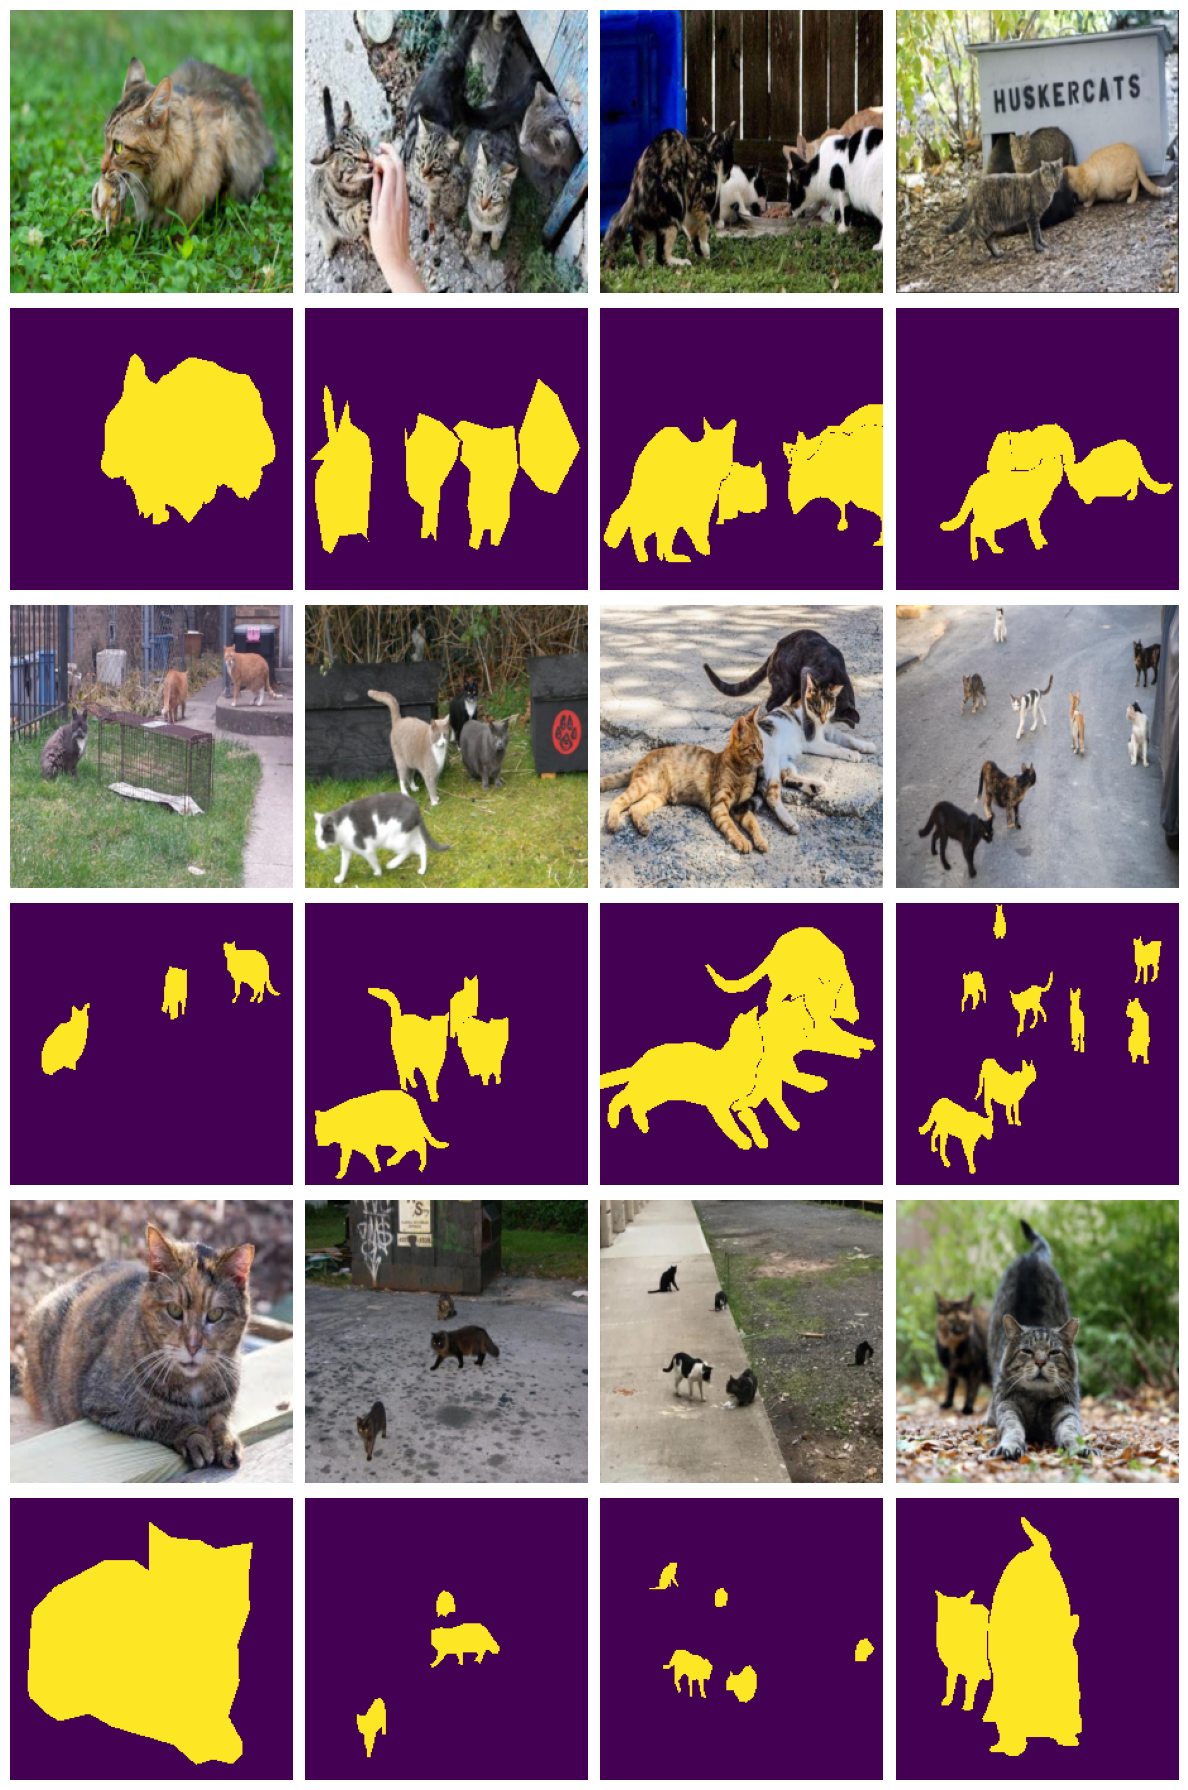

### No errors for test - 12 masks ###

### Number of files ### 
Images: 2054 	|	Json: 2054


100%|██████████| 12/12 [00:00<00:00, 66.38it/s]


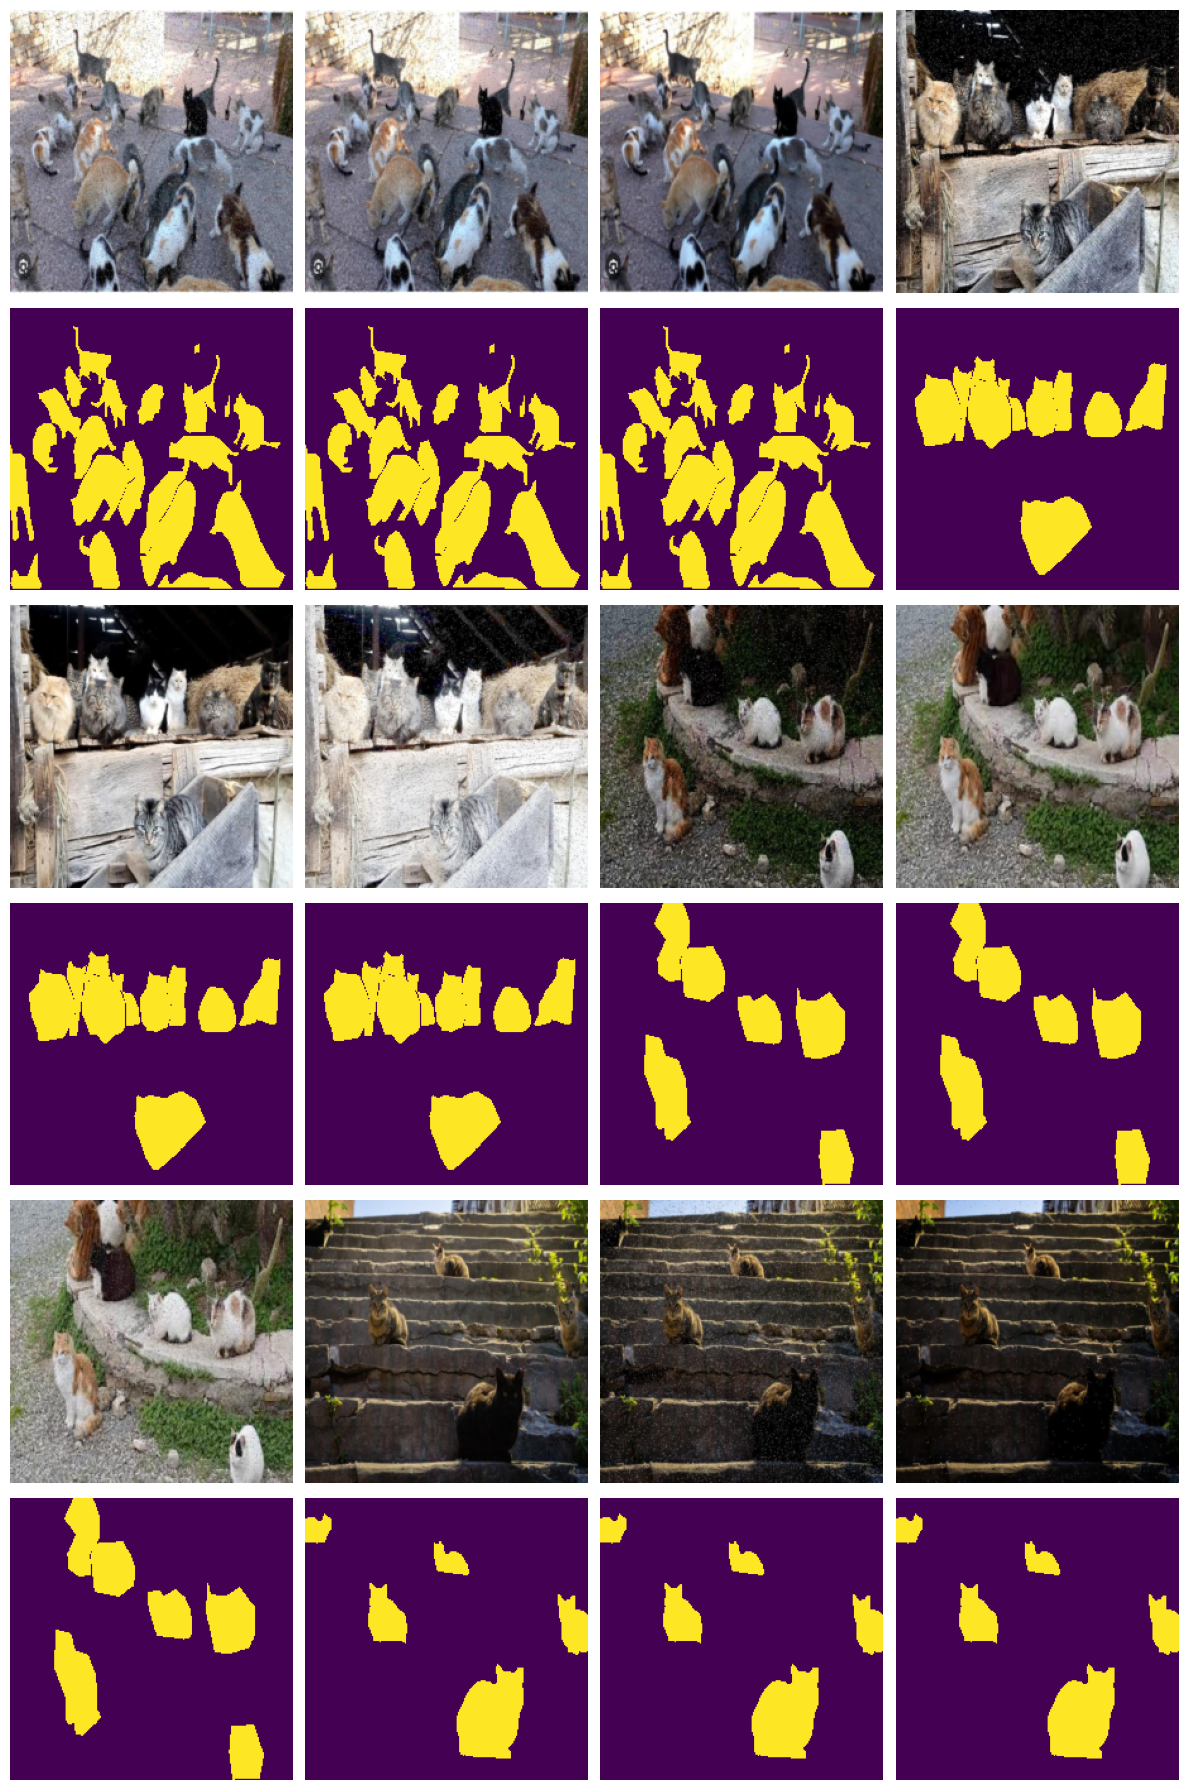

### No errors for train - 12 masks ###

### Number of files ### 
Images: 195 	|	Json: 195


100%|██████████| 12/12 [00:00<00:00, 146.34it/s]


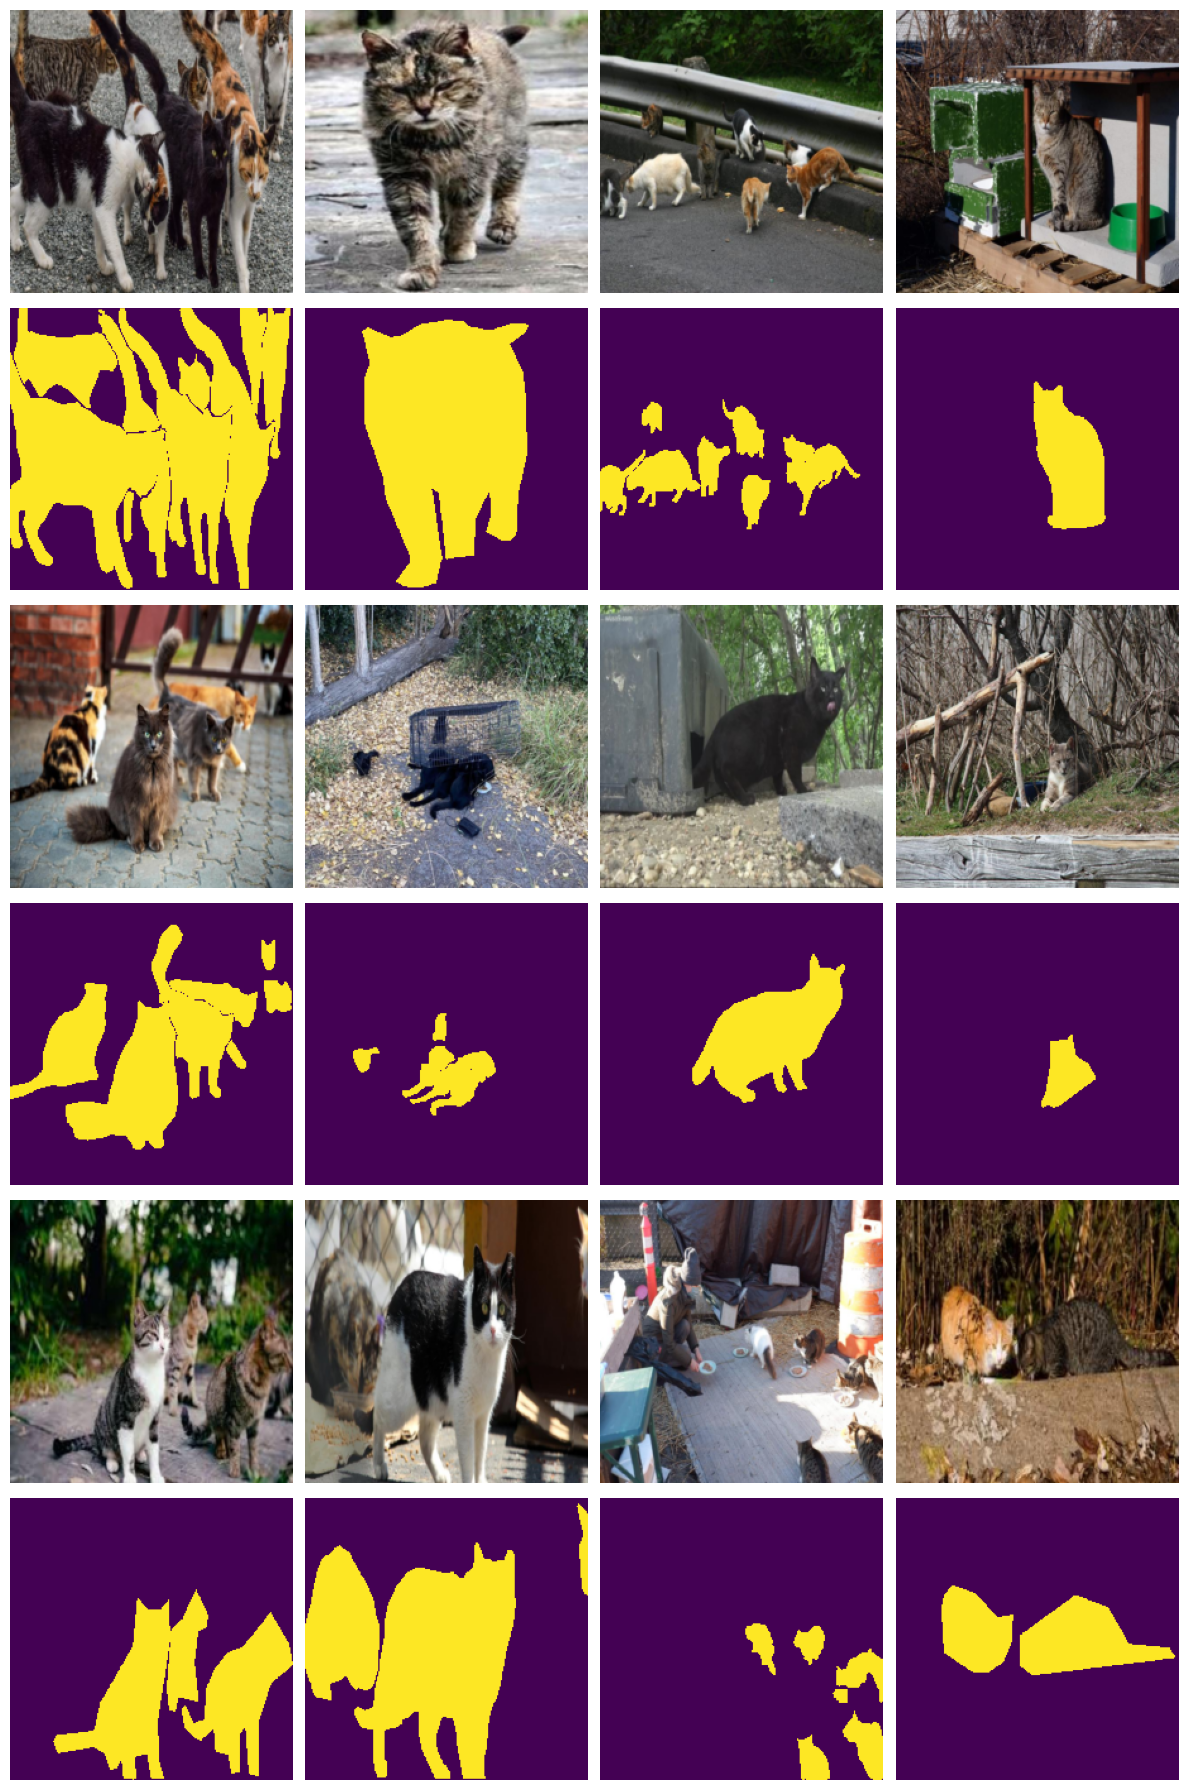

### No errors for valid - 12 masks ###



In [8]:
preprocess_catpp()